In [1]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

from utils import load_dataframe, show_images
from tuberculosis_dataset import TuberculosisDataset

In [2]:
#Model Hiperparameters
EPOCHS=50
BATCH_SIZE = 16
IMG_SIZE = (224,224)

# File paths
dataset_description_path = "dataset_description.yaml"

In [3]:
tb_df = load_dataframe(dataset_description_path)

In [4]:
tb_df

,file,path,abnormal,tuberculosis
0,00000562_000.png,dataset/anormal-xr-no_tb/00000562_000.png,1,0
1,00000199_002.png,dataset/anormal-xr-no_tb/00000199_002.png,1,0
2,00000628_000.png,dataset/anormal-xr-no_tb/00000628_000.png,1,0
3,00000897_000.png,dataset/anormal-xr-no_tb/00000897_000.png,1,0
4,00000830_006.png,dataset/anormal-xr-no_tb/00000830_006.png,1,0
...,...,...,...,...
15753,Tuberculosis-49.png,dataset/TB_Chest_Radiography_Database/Tubercul...,1,1
15754,Tuberculosis-127.png,dataset/TB_Chest_Radiography_Database/Tubercul...,1,1
15755,Tuberculosis-166.png,dataset/TB_Chest_Radiography_Database/Tubercul...,1,1
15756,Tuberculosis-237.png,dataset/TB_Chest_Radiography_Database/Tubercul...,1,1


In [5]:
total = tb_df.count()

In [6]:
total

file            15758
path            15758
abnormal        15758
tuberculosis    15758
dtype: int64

In [7]:
data_distribution = tb_df[['abnormal', 'tuberculosis']].value_counts()

<AxesSubplot: xlabel='abnormal,tuberculosis'>

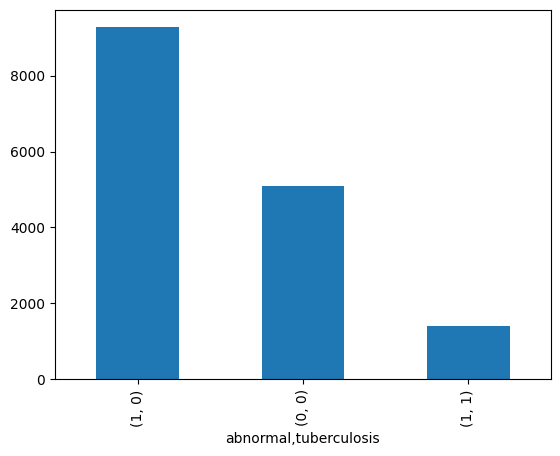

In [8]:
data_distribution.plot(kind='bar')

In [9]:
##Initialize Dataset
imgs_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor()
])
tb_dataset = TuberculosisDataset(dataframe=tb_df, transforms=imgs_transforms)

train_loader = DataLoader(tb_dataset, batch_size=BATCH_SIZE, shuffle=True)

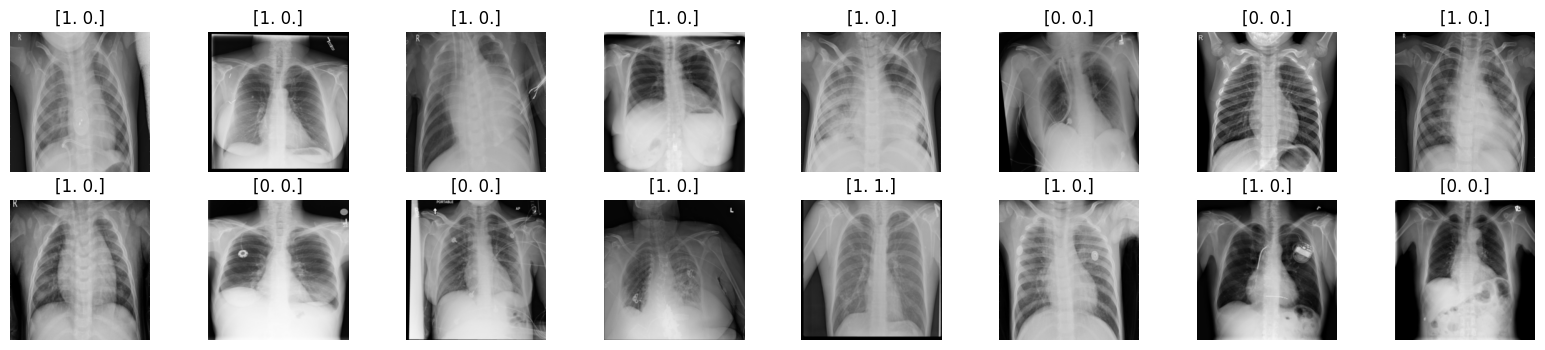

In [10]:
import numpy as np
images, labels = next(iter(train_loader))
images = [np.transpose(img.numpy(), (1, 2, 0)) for img in images]
labels = labels.numpy()

show_images(images, labels)